The notebook shows an example how text files, labelled for sentiment (positive or negative), can be converted to a tabular format and then used to train a machine learning model capable of classifying new texts by sentiment.

As an example, we will use a corpus of movie reviews first used in Pang and Lee (2004), for details see [here](http://www.cs.cornell.edu/people/pabo/movie-review-data/).

In [1]:
# setting logging to print only error messages of sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import matplotlib.pyplot as plt

# execution time
from timeit import default_timer as timer
from datetime import timedelta

# Load the data

If the data has not been downloaded before, download it, and save to a folder called "datasets", alongside this notebook.

In [2]:
import os
import urllib
import tarfile

url = "https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz"

def download_data(url):
    """Download the data and extract the mo
    """

    # if the "datasets" folder does not exist, create it
    if not os.path.exists("datasets"):
        os.makedirs("datasets")

    # if the archived file does not exist, download it
    if not os.path.exists("datasets/review_polarity.tar.gz"):
        urllib.request.urlretrieve(url, "datasets/review_polarity.tar.gz")

    # if the unpacked file does not exist, unpack it
    if not os.path.exists("datasets/txt_sentoken"):
        infile = tarfile.open("datasets/review_polarity.tar.gz")
        infile.extractall(path="datasets")
        infile.close()

download_data(url)

/tmp/ipython-input-2070399950.py:22: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  infile.extractall(path="datasets")


The code above will produce a folder inside "datasets", called "txt_sentoken". That folder will contain two subfolders - "pos" (containing 1000 files manually labelled as positive) and "neg" (containing 1000 files manually labelled as "negative"). Each file is a separate movie review, after minimal normalization (inserting spaces around punctuation symbols, lower-casing all words, etc).

We will use Scikit-learn's `load_files` function to load the data and then store it in a Pandas dataframe:

In [3]:
from sklearn.datasets import load_files

# loading all files.
movie = load_files("./datasets/txt_sentoken/", shuffle=True)

In [4]:
len(movie.data)

2000

In [5]:
# target names ("classes") are automatically generated from subfolder names
movie.target_names

['neg', 'pos']

In [6]:
# First file seems to be about a Schwarzenegger movie.
print(movie.data[0])

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the film is 

In [7]:
movie.target[0]

np.int64(0)

In [8]:
df = pd.DataFrame({"text": movie.data, "label": movie.target})
df["text"] = df["text"].astype("str")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [9]:
# keep the first 512 tokens in each document
def f(r):
    tokens = r["text"].split(" ")[:512]
    r["text"] = ' '.join(tokens)
    return r

df = df.apply(f, axis=1)

# Train-test split

In [10]:
from sklearn.model_selection import train_test_split

docs_train, docs_test, ytrain, ytest = train_test_split(df["text"], df["label"],
                                                          test_size=0.2, random_state=7)

In [11]:
print(f"{len(docs_train)} train and {len(docs_test)} test instances")

1600 train and 400 test instances


# Data transformation

## Create Bag-of-Words representations

`CountVectorizer` is a convenient facility to create bag-of-words representations of documents into a numpy array. Setting the arguments of the constructor class, we can configure the basic linguistic preprocessing steps that should be applied to it: supplying a custom tokenizer, stopword list, ngram range, etc.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(
    strip_accents="unicode", # convert accented chars to non-accented versions
    lowercase=True,
    tokenizer=None,        # None - use the default tokenizer
    preprocessor=None,     # None - use the default preprocessor
    stop_words="english",
    ngram_range=(1,1),     # min and max range of ngrams
    analyzer="word",       # split the document into words, rather than e.g. characters
    max_df=1.0,            # ignore words with df greater than the value (int represents count,
                           # float represents proportion of documents)
    min_df=1               # ignore words the df lower than the value (int represents count,
                           # float represents proportion)
)

We first create an instance of `CountVectorizer` and then call its `fit_transform` method. It first "fits" on the data, i.e., extracts individual features from each document, as specified by the arguments to the constructor method (e.g., extract bigrams), and then "transforms" the data, i.e. creates numpy arrays where rows are documents, columns are features extracted from the documents, and values in the cells are counts of each feature in each document:

In [13]:
# fit and tranform using training text
docs_train_counts = count_vectorizer.fit_transform(docs_train)

In [14]:
docs_train_counts.shape

(1600, 30876)

Thus, there 1600 rows, one for each document, and 36304 columns, one for each feature.

Let's check the datatype of the data:

In [15]:
type(docs_train_counts)

scipy.sparse._csr.csr_matrix

Note the data is stored in a special data structure called "sparse matrix", specifically Compressed Sparse Row. Because there are many zeros in each row (in the first row, there are 139 non-zero values, out of the total of 36034), the sparse matrix stores the data more efficiently and thus is able to represent relatively large text collections, without running into memory errors.

We can, however, convert a sparse matrix to a normal, "dense", numpy array, if needed:

In [16]:
docs_train_counts[0, :].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

The fitted `count_vectorizer` stores also the vocabulary of the text collection on which it was fitted.

In [17]:
count_vectorizer.vocabulary_

{'plot': 20651,
 'realization': 22128,
 'failing': 9963,
 'classes': 5153,
 'roommates': 23368,
 'try': 28421,
 'roomie': 23364,
 'kill': 15228,
 'school': 23968,
 'charter': 4768,
 'automatically': 2175,
 'grants': 11921,
 'grades': 11876,
 'student': 26491,
 'succeeds': 26638,
 'suicide': 26700,
 'critique': 6550,
 'despite': 7503,
 'film': 10356,
 'interesting': 14321,
 'premise': 21094,
 'dark': 6944,
 'subject': 26564,
 'matter': 17053,
 'movie': 18101,
 'sucks': 26661,
 'unfunny': 28893,
 'boring': 3457,
 'presents': 21134,
 'tom': 27917,
 'everett': 9546,
 'scott': 24045,
 'worst': 30533,
 'acting': 719,
 'performances': 20143,
 'add': 762,
 'completely': 5672,
 'unsuccessful': 29110,
 'romance': 23325,
 'element': 8907,
 'lame': 15545,
 'corny': 6217,
 'jokes': 14874,
 'long': 16272,
 'wait': 29810,
 'setup': 24429,
 'ending': 9150,
 'takes': 27173,
 'blackness': 3101,
 'black': 3091,
 'comedy': 5535,
 'gonna': 11771,
 'create': 6457,
 'don': 8227,
 'chicken': 4889,
 'end': 913

The vocabulary is just a dictionary, where keys are original words and values are their indices in the produced matrix. The vocabulary will be used internally by the fitted vectorizer, when we transform the test data, deriving a document-by-feature matrix, which has the same columns in the same order as the training data.

Let's apply the fitted vectorizer also to the test data. Note we call the `transform` method, not `fit` or `fit_transform`, because the vectorizer has been fitted already:

In [18]:
docs_test_counts = count_vectorizer.transform(docs_test)

In [19]:
docs_test_counts.shape

(400, 30876)

It has 400 rows (one per document), but the same number of columns as the training data, 36034.

## TF-IDF weighting

Further, we can transform the observed counts into TF-IDF weights in order to reflect the importance of every word in the document. This is achieved with `TfidfTransformer`:

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

First the transformer needs to be "fitted" on the training data and then the fitted transformer should be used to transform both the training and the test data:

In [21]:
# fit and transform the training set with "fit_transform()"
docs_train_tfidf = tfidf_transformer.fit_transform(docs_train_counts)

In [22]:
# transform test
docs_test_tfidf = tfidf_transformer.transform(docs_test_counts)

## Standardize features

Fit a scaler on the training set and use it to transform both the training and test sets. We'll use a `MaxAbsScaler` as it is capable of dealing with sparse matrices.

In [23]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()

Xtrain = scaler.fit_transform(docs_train_tfidf)
Xtest = scaler.transform(docs_test_tfidf)

In [24]:
Xtrain

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 272436 stored elements and shape (1600, 30876)>

# Train models

In [25]:
from sklearn.model_selection import GridSearchCV

## Baseline

Classifying everything as "pos"

*pos*:
* precision: 800/1600 = 0.5
* recall: 800/800 = 1.0
* f-score: 2/(1/p + 1/r) = 0.66

*neg*:
* precision: 0/0 = 0.0
* recall: 0/800 = 0.0
* f-score: 2/(1/p + 1/r) = 0.0

*Macro-averaged*:
* precision: 0.25
* recall: 0.5
* **f-score: 0.33**

In [26]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_fscore_support

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(Xtrain, ytrain)
yhat = dummy_clf.predict(Xtrain)

p, r, f, s = precision_recall_fscore_support(ytrain, yhat, average="macro", zero_division=0.0)
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")

Precision: 0.254
Recall: 0.500
F score: 0.337


## Decision Trees

In [27]:
start = timer()

from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(random_state=7)

# specify the hyperparameters and their values
# 3 x 3 = 9 combinations in the grid
param_grid = {
    'max_depth': [5, 15, 30],
    'min_samples_split': [5, 10, 20],
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(dtree, param_grid, cv=5,
                           scoring='f1_macro',
                           return_train_score=True)
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:00:50.647860


In [28]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
3,"{'max_depth': 15, 'min_samples_split': 5}",0.892681,0.637214,28.617944
5,"{'max_depth': 15, 'min_samples_split': 20}",0.868265,0.633583,27.028854
4,"{'max_depth': 15, 'min_samples_split': 10}",0.884752,0.628786,28.930807
2,"{'max_depth': 5, 'min_samples_split': 20}",0.719397,0.623278,13.361100
6,"{'max_depth': 30, 'min_samples_split': 5}",0.967804,0.622156,35.714700
1,"{'max_depth': 5, 'min_samples_split': 10}",0.719295,0.621816,13.551957
0,"{'max_depth': 5, 'min_samples_split': 5}",0.720827,0.621730,13.747715
7,"{'max_depth': 30, 'min_samples_split': 10}",0.948580,0.613267,35.348904
8,"{'max_depth': 30, 'min_samples_split': 20}",0.920929,0.610743,33.681797


## Random Forest

In [29]:
start = timer()

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=7)

# specify the hyperparameters and their values
# 4 x 3 x 3 = 36 combinations in the grid
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [5, 15, 30],
    'min_samples_split': [5, 10, 20]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='f1_macro',
                           return_train_score=True)
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:16:11.409910


In [30]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
33,"{'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 200}",0.988750,0.745372,24.614707
29,"{'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 200}",0.992812,0.744368,25.024211
30,"{'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 500}",0.992343,0.743949,25.031043
34,"{'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 500}",0.987812,0.738974,25.190844
19,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 1000}",0.976874,0.737725,24.481070
13,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}",0.977343,0.737088,24.582451
22,"{'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 500}",0.971715,0.736548,24.201245
18,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 500}",0.976093,0.735838,24.613906
23,"{'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 1000}",0.972810,0.735541,24.390083
28,"{'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 100}",0.992499,0.734554,25.989464


Let's view the most important features:

In [31]:
# put them into a separate variable for convenience
feature_importances = grid_search.best_estimator_.feature_importances_

# the order of the features in `feature_importances` is the same as in count_vectorizer.get_feature_names(),
# so we can "zip" the two and print the first 50 in the descending order:
for k, v in sorted(zip(feature_importances, count_vectorizer.get_feature_names_out()), reverse=True)[:50]:
    print(f"{v}: {k:.5f}")

bad: 0.01448
worst: 0.00798
supposed: 0.00534
boring: 0.00504
plot: 0.00499
life: 0.00493
movie: 0.00453
script: 0.00418
reason: 0.00391
dull: 0.00365
mess: 0.00352
unfortunately: 0.00341
wasted: 0.00339
joke: 0.00327
stupid: 0.00323
make: 0.00306
just: 0.00294
talent: 0.00291
different: 0.00263
lame: 0.00255
poor: 0.00253
tries: 0.00242
minute: 0.00242
better: 0.00240
awful: 0.00240
minutes: 0.00237
thing: 0.00235
big: 0.00233
ridiculous: 0.00233
american: 0.00231
attempt: 0.00221
clich: 0.00218
wouldn: 0.00216
problem: 0.00210
looks: 0.00202
waste: 0.00200
given: 0.00197
true: 0.00192
hilarious: 0.00188
look: 0.00179
annoying: 0.00179
video: 0.00178
brilliant: 0.00176
don: 0.00176
like: 0.00171
seen: 0.00168
terrific: 0.00168
day: 0.00165
fails: 0.00165
acting: 0.00159


In [32]:
from joblib import dump

# create a folder where all trained models will be kept
if not os.path.exists("models"):
    os.makedirs("models")

dump(grid_search.best_estimator_, 'models/rf-clf.joblib')

['models/rf-clf.joblib']

## Linear SVM

In [33]:
start = timer()

from sklearn.svm import LinearSVC

lsvm = LinearSVC(random_state=7, max_iter=10000)

# specify the hyperparameters and their values
# 7 combinations in the grid
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(lsvm, param_grid, cv=5,
                           scoring='f1_macro',
                           return_train_score=True)
grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Execution time HH:MM:SS: 0:00:10.241055


In [34]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
2,{'C': 0.01},1.000000,0.809963,19.003667
3,{'C': 0.1},1.000000,0.806842,19.315795
5,{'C': 5},1.000000,0.806828,19.317191
6,{'C': 10},1.000000,0.806828,19.317191
4,{'C': 1},1.000000,0.806201,19.379862
1,{'C': 0.001},0.989054,0.788382,20.289249
0,{'C': 0.0001},0.902476,0.634466,29.697170


Save the best model to disk:

In [35]:
dump(grid_search.best_estimator_, 'models/svm-linear-clf.joblib')

['models/svm-linear-clf.joblib']

# Evaluate on test

In [36]:
from joblib import load
from sklearn.metrics import precision_recall_fscore_support

lsvm = load("models/svm-linear-clf.joblib")

yhat = lsvm.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, yhat, average="macro")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

Precision: 0.811541261831237
Recall: 0.8117525876796301
F score: 0.8116417929189872


The accuracy scores on the test set turn out to be very similar to the one achieved during cross-validation.

Plot a confusion matrix:

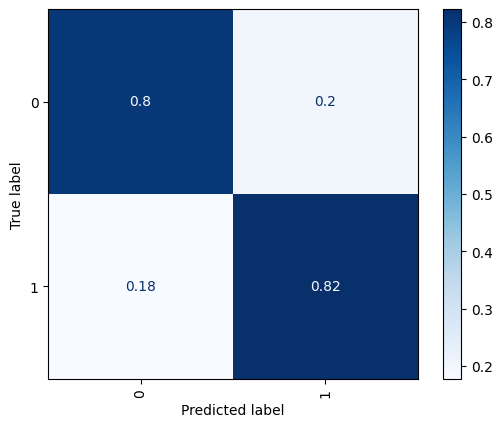

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(ytest, yhat, labels=lsvm.classes_,
                                        xticks_rotation="vertical", normalize="true",
                                        cmap=plt.cm.Blues)

# Classify previously unseen reviews

Some reviews from the Rotten Tomatoes website:

In [38]:
new_reviews = [
               """Never let the audience off the hook, Hitchcock once said.
               Ho achieves this in spades and with more than one hook.""",

               """The smartest mainstream film about class made in many
               years, Bong Joon-ho's Parasite lays bare the lie that hard
               work can bring anyone closer to their dreams.""",

               """[A] funny, inventive, scary film."""
            ]

# preprocess and transform
new_reviews_counts = count_vectorizer.transform(new_reviews)
new_reviews_tfidf = tfidf_transformer.transform(new_reviews_counts)
new_scaled = scaler.transform(new_reviews_tfidf)

# predict labels
predictions = lsvm.predict(new_scaled)

# print results
for review, category in zip(new_reviews, predictions):
    print(f'{review} => {movie.target_names[category]}\n')

Never let the audience off the hook, Hitchcock once said. 
               Ho achieves this in spades and with more than one hook. => neg

The smartest mainstream film about class made in many 
               years, Bong Joon-ho's Parasite lays bare the lie that hard 
               work can bring anyone closer to their dreams. => pos

[A] funny, inventive, scary film. => pos



# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2024). Machine Learning for Business Analytics. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm